# RockPaperScissors - image classification model

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [2]:
if tf.__version__<"2.2.0":
     raise UserWarning("Requires TensorFlow 2.2.0+!")

## Create a model

In [3]:
from pathlib import Path
dataset_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip"
data_dir = tf.keras.utils.get_file('rps.zip', origin=dataset_url, extract=True)

extensions = [".zip",".rar",".tar"]

for i in range(0,len(extensions)):
    if extensions[i]==data_dir[len(data_dir)-4]+data_dir[len(data_dir)-3]+data_dir[len(data_dir)-2]+data_dir[len(data_dir)-1]:
        data_dir = data_dir[:-4]
data_dir = Path(data_dir)

In [4]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2520 files belonging to 3 classes.
Using 2016 files for training.
Found 2520 files belonging to 3 classes.
Using 504 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['paper', 'rock', 'scissors']


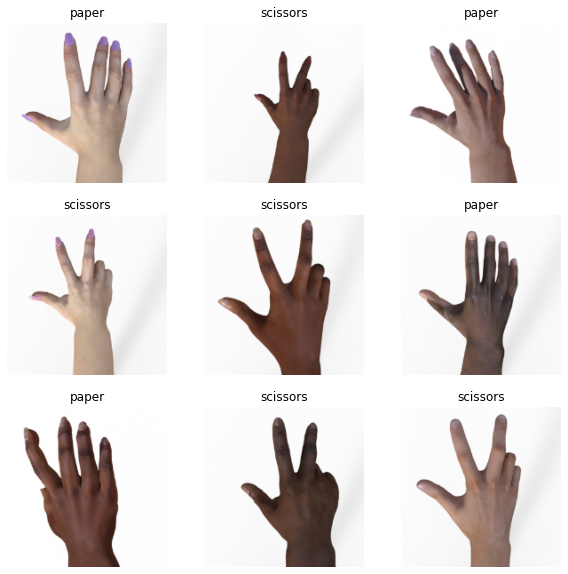

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [9]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.044444486 1.0


In [11]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomZoom(0.3),
  ]
)

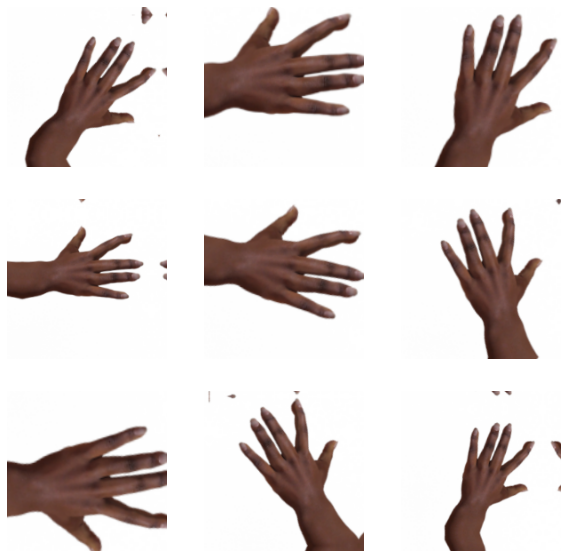

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

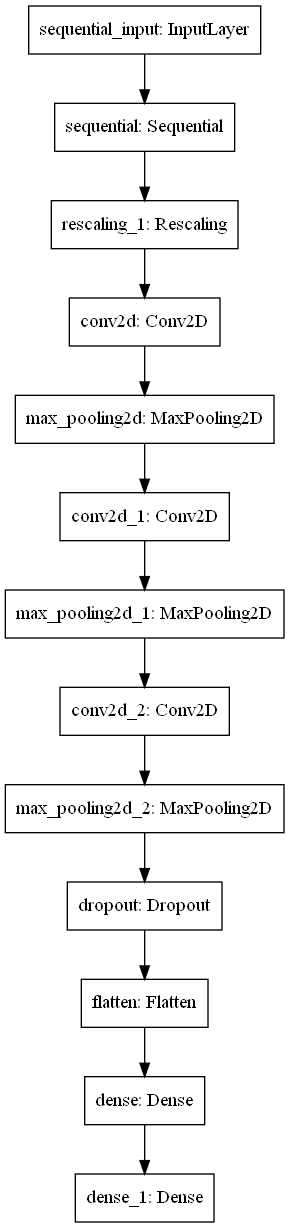

In [13]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names))
])
keras.utils.plot_model(model)

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [16]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
63/63 [==============================] - 54s 782ms/step - loss: 1.1151 - accuracy: 0.4008 - val_loss: 0.9827 - val_accuracy: 0.3869
Epoch 2/15
63/63 [==============================] - 48s 730ms/step - loss: 0.6957 - accuracy: 0.6949 - val_loss: 0.5850 - val_accuracy: 0.7262
Epoch 3/15
63/63 [==============================] - 74s 1s/step - loss: 0.5123 - accuracy: 0.7842 - val_loss: 0.3138 - val_accuracy: 0.8889
Epoch 4/15
63/63 [==============================] - 82s 1s/step - loss: 0.3437 - accuracy: 0.8651 - val_loss: 0.2095 - val_accuracy: 0.9345
Epoch 5/15
63/63 [==============================] - 61s 899ms/step - loss: 0.2564 - accuracy: 0.9072 - val_loss: 0.1779 - val_accuracy: 0.9464
Epoch 6/15
63/63 [==============================] - 46s 699ms/step - loss: 0.2210 - accuracy: 0.9187 - val_loss: 0.2588 - val_accuracy: 0.9067
Epoch 7/15
63/63 [==============================] - 49s 753ms/step - loss: 0.1986 - accuracy: 0.9276 - val_loss: 0.2184 - val_accuracy: 0.9067
Epoch

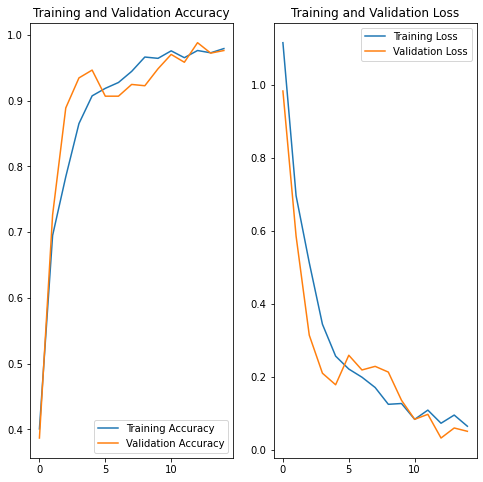

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## New data verification

In [18]:
dataset_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip"
data_dir = tf.keras.utils.get_file('rps-test-set.zip', origin=dataset_url, extract=True)

extensions = [".zip",".rar",".tar"]
for i in range(0,len(extensions)):
    if extensions[i]==data_dir[len(data_dir)-4]+data_dir[len(data_dir)-3]+data_dir[len(data_dir)-2]+data_dir[len(data_dir)-1]:
        data_dir = data_dir[:-4]
data_dir = Path(data_dir)

In [19]:
for i in range(0, len(class_names)):
    correct_predictions=0
    test_class_set = str(data_dir)+"\\"+class_names[i]
    test_class_set = Path(test_class_set)
    image_count = len(list(test_class_set.glob('*.*')))
    list_of_files=list(test_class_set.glob('*.*'))
    
    for j in range(0, len(list_of_files)):
        img = tf.keras.preprocessing.image.load_img(
        list_of_files[j] , target_size=(img_height, img_width)
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
       
        if class_names[np.argmax(score)]==class_names[i]:
            correct_predictions+=1
            
    print(
        "{}: {:.2f} percent success rate."
        .format(class_names[i], 100*correct_predictions/image_count)
    )

paper: 87.10 percent success rate.
rock: 99.19 percent success rate.
scissors: 100.00 percent success rate.
